In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
"""
统计分析 collect_data 得到的数据
"""
import pymongo
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
from matplotlib.font_manager import FontProperties

db = pymongo.MongoClient('127.0.0.1', 27017).get_database('analysis')
answer_coll = db.answer
influence_coll = db.influence
receiver_coll = db.receiver
F = 'follow'
N = 'notification'
Q = 'qlink'
R = 'recommendation'
ChineseFont2 = FontProperties('SimHei')



def follower_receivers():
    """follower对upvoters, commenters, collectors数目的影响"""
    follower, upvoter, commenter, collector = [], [], [], []
    for answer in answer_coll.find():
        if answer['fo_count'] is None:
            continue
        follower.append(answer['fo_count'])
        upvoter.append(answer['upvote_num'])
        commenter.append(answer['comment_num'])
        collector.append(answer['collect_num'])
    return follower, upvoter, commenter, collector

def follower_distance():
    """
    follower数目对传播距离的影响
    """
    x, y = [], []
    for answer in answer_coll.find():
        fo_count = answer['fo_count']
        if fo_count is None:
            continue
        distance = answer['layer']
        x.append(fo_count)
        y.append(distance)
    return x, y

def upvote_distance():
    x, y = [], []
    for answer in answer_coll.find():
        upvote_num = answer['upvote_num']
        distance = answer['layer']
        x.append(upvote_num)
        y.append(distance)
    return x, y

def relation_type():
    """统计关系类型"""
    Distance, Follower, Upvote, data = [], [], [], []
    for answer in answer_coll.find():
        f = answer[F]
        n = answer[N]
        q = answer[Q]
        r = answer[R]
        Distance.append(answer['layer'])
        Follower.append(answer['fo_count'])
        Upvote.append(answer['upvote_num'])
        data.append({F: f, N: n, Q: q, R: r})
    return Distance, Follower, Upvote, data

def spread():
    """扩散速度"""
    follower = []
    times = []
    for receiver in receiver_coll.find():
        if receiver['fo_count'] is None:
            continue
        follower.append(receiver['fo_count'])
        times.append(receiver['time'])
    return follower, times

def ten_split(X, Y):
    """按照x取0~10%,10%~20%,...,90%~100%，计算每一段的平均值"""
    bins = np.linspace(min(X), max(X), num=10)
    return bins

def log_ten_split(X, Y):
    """按照log10(x)取0~10%,10%~20%,...,90%~100%，计算每一段的平均值"""
    from cmath import log10
    min_x = log10(1)
    max_x = log10(max(X))
    bins = np.logspace(min_x, max_x, num=10)
    X = [x if x > 0 else 1 for x in X]
    bin_means = np.histogram(X, bins=bins, weights=Y)[0]/np.histogram(X, bins=bins)[0]
    return bins, bin_means

12 13


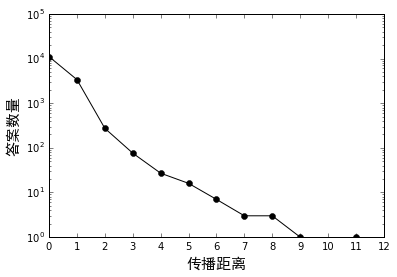

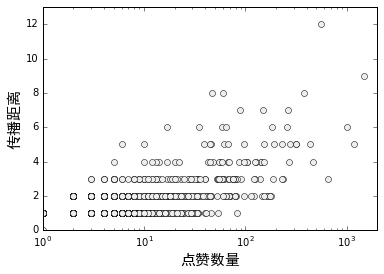

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


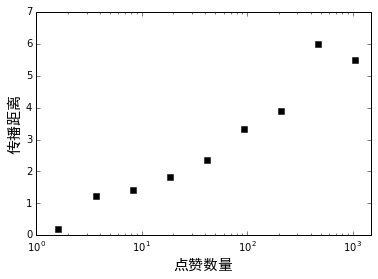

676527


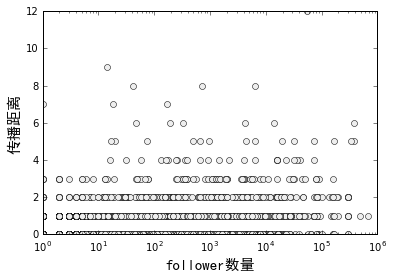

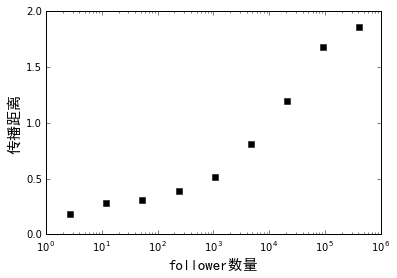

In [8]:
# 传播距离相关
upvote, distance = upvote_distance()

# 统计
values, base = np.histogram(distance, bins=list(range(13)))
print(len(values), len(base))
pyplot.yscale('log')
plt.plot(base[:-1], values, 'bo-', color='black')
plt.xticks(np.arange(min(base), max(base)+1, 1.0))
plt.xlabel("传播距离", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("答案数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

# 点赞数目 - 传播距离
plt.plot(upvote, distance, 'go', color='#EEEEEE')
pyplot.xscale('log')
pyplot.axis([1,2000,0,13])
plt.xlabel("点赞数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("传播距离", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

bins, bin_means = log_ten_split(upvote, distance)
X = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(X, bin_means, 'rs', color='black')
pyplot.xscale('log')
pyplot.axis([1,1500,0,7])
plt.xlabel("点赞数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("传播距离", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

# follower - 传播距离
fo_count, distance = follower_distance()
print(max(fo_count))
plt.plot(fo_count, distance, 'go', color='#EEEEEE')
pyplot.xscale('log')
#pyplot.axis([1,2000,0,13])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("传播距离", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

bins, bin_means = log_ten_split(fo_count, distance)
X = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(X, bin_means, 'rs', color='black')
pyplot.xscale('log')
#pyplot.axis([1,1500,0,7])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("传播距离", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

OrderedDict([('follow', 12896), ('notification', 1705), ('qlink', 11187), ('recommendation', 4874)])
{'follow': 21.84, 'notification': 10.85, 'qlink': 45.210000000000001, 'recommendation': 22.109999999999999}
{'follow': 29.559999999999999, 'notification': 7.4100000000000001, 'qlink': 49.100000000000001, 'recommendation': 13.94}
{'follow': 34.57, 'notification': 4.3300000000000001, 'qlink': 40.700000000000003, 'recommendation': 20.399999999999999}
{'follow': 67.040000000000006, 'notification': 1.03, 'qlink': 22.48, 'recommendation': 9.4499999999999993}


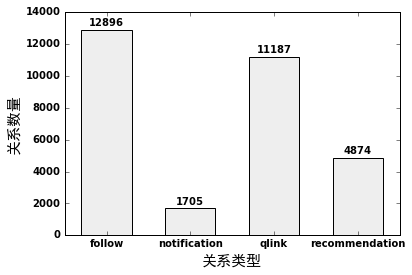

In [18]:
# 关系类型相关
# 得排除掉全0的
distance, follower, upvote, data = relation_type()

from collections import OrderedDict
relations = OrderedDict([(F,0), (N,0), (Q,0), (R,0)])

# 统计所有关系
for d in data:
    for key in relations:
        relations[key] += d[key]
        
print(relations)

ax = plt.bar(range(len(relations)), relations.values(), align='center', color='#EEEEEE', width=0.6)
plt.xticks(range(len(relations)), relations.keys())
plt.xlabel("关系类型", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("关系数量", fontproperties = ChineseFont2, fontsize=15)
for rect, label in zip(ax.patches, relations.values()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height + 100, label, ha='center', va='bottom')
    
# 计算不同 upvote, follower 下四种关系的比例
f100 = OrderedDict([(F,0), (N,0), (Q,0), (R,0)])
f100to500 = OrderedDict([(F,0), (N,0), (Q,0), (R,0)])
f500to2000 = OrderedDict([(F,0), (N,0), (Q,0), (R,0)])
f2000 = OrderedDict([(F,0), (N,0), (Q,0), (R,0)])

for fo_count, d in zip(follower, data):
    if fo_count is None:
        continue
    if fo_count < 100:
        relations = f100
    elif 100 <= fo_count < 500:
        relations = f100to500
    elif 500 <= fo_count < 2000:
        relations = f500to2000
    else:
        relations = f2000
    for key in relations:
        relations[key] += d[key]

for relations in (f100, f100to500, f500to2000, f2000):
    print({key: round(100*value/sum(list(relations.values())),2) for key, value in relations.items()})

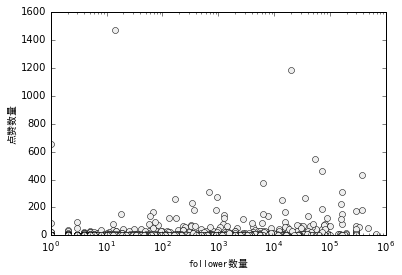

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


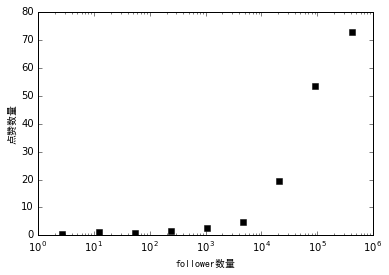

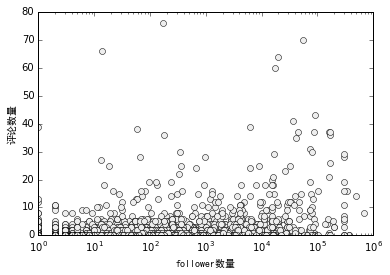

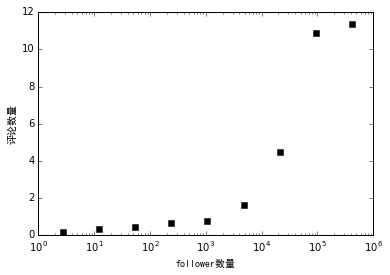

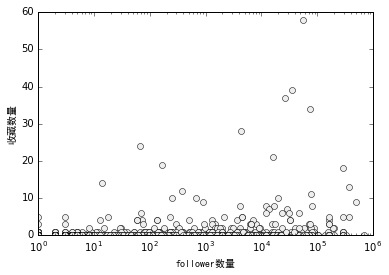

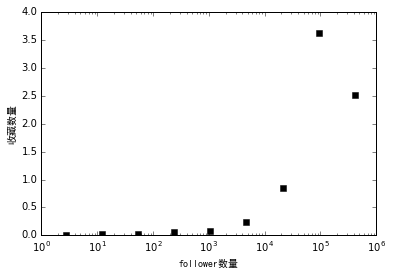

In [6]:
# 统计 follower 对接收者数量的影响

follower, upvoter, commenter, collector = follower_receivers()

# follower - upvoter
plt.plot(follower, upvoter, 'go', color='#EEEEEE')
pyplot.xscale('log')
#pyplot.axis([1,2000,0,13])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("点赞数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

bins, bin_means = log_ten_split(follower, upvoter)
X = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(X, bin_means, 'rs', color='black')
pyplot.xscale('log')
#pyplot.axis([1,1500,0,7])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("点赞数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

# follower - commenter
plt.plot(follower, commenter, 'go', color='#EEEEEE')
pyplot.xscale('log')
#pyplot.axis([1,2000,0,13])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("评论数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

bins, bin_means = log_ten_split(follower, commenter)
X = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(X, bin_means, 'rs', color='black')
pyplot.xscale('log')
#pyplot.axis([1,1500,0,7])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("评论数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

# follower - collector
plt.plot(follower, collector, 'go', color='#EEEEEE')
pyplot.xscale('log')
#pyplot.axis([1,2000,0,13])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("收藏数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

bins, bin_means = log_ten_split(follower, collector)
X = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(X, bin_means, 'rs', color='black')
pyplot.xscale('log')
#pyplot.axis([1,1500,0,7])
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("收藏数量", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

[ 599   82   35   15   17   10   25   73  116  150  120  164  258  438  761
 1044 1185 1445  947  988 1086  886  901  906]


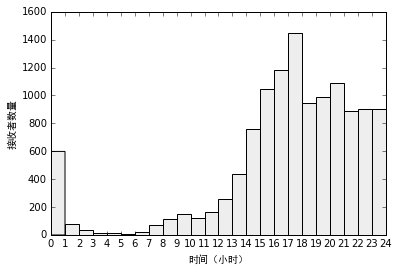

In [7]:
# receivers 时间分布
from functools import reduce

fo_count, times = spread()
occurance_list = reduce(lambda x, y: x+y, times)

def chart(occurance_list):
    hour_list = [t.hour for t in occurance_list]
    bins = list(range(25))
    values, _ = np.histogram(hour_list, bins=bins)
    print(values) 
    plt.xticks(bins, [str(t) for t in bins])
    plt.xlim(0,24)
    plt.xlabel("时间（小时）", fontproperties = ChineseFont2, fontsize=15)
    plt.ylabel("接收者数量", fontproperties = ChineseFont2, fontsize=15)
    plt.hist(hour_list, bins=bins, color='#EEEEEE')

    
chart(occurance_list)

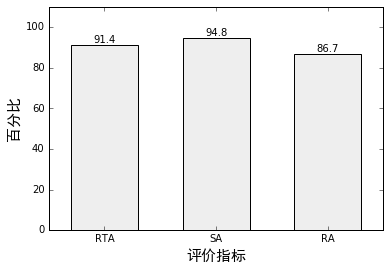

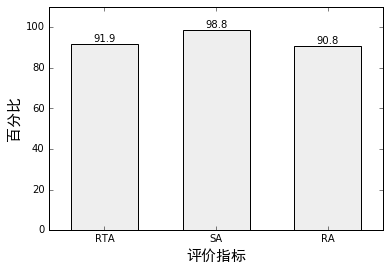

1025


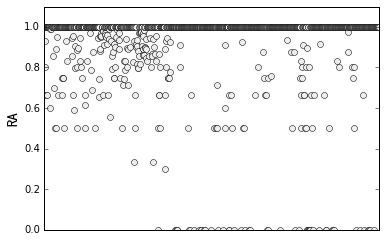

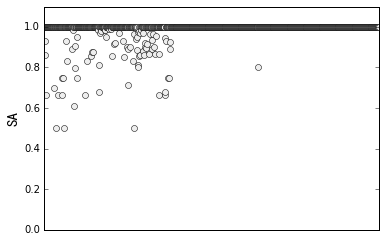

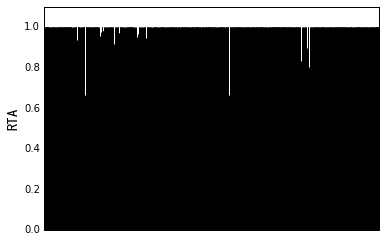

In [26]:
# 总平均
results = {'RTA': 91.4, 'SA': 94.8, 'RA': 86.7}
ax = plt.bar(range(len(results)), results.values(), align='center', width=0.6, color='#EEEEEE')
plt.xticks(range(len(results)), results.keys())
plt.gca().axes.set_ylim([0, 110])
plt.xlabel("评价指标", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("百分比", fontproperties = ChineseFont2, fontsize=15)
for rect, label in zip(ax.patches, results.values()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height + 0.02, label, ha='center', va='bottom')

plt.show()
# 分答案平均 
results = {'RTA': 91.9, 'SA': 98.8, 'RA': 90.8}
ax = plt.bar(range(len(results)), results.values(), align='center', width=0.6, color='#EEEEEE')
plt.xticks(range(len(results)), results.keys())
plt.gca().axes.set_ylim([0, 110])
plt.xlabel("评价指标", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("百分比", fontproperties = ChineseFont2, fontsize=15)
for rect, label in zip(ax.patches, results.values()):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height + 0.02, label, ha='center', va='bottom')
plt.show()
    
import pickle
with open('../data/fuck.pkl', 'rb') as f:
    data = pickle.load(f)
print(len(data['RA']))
    
plt.plot(range(len(data['RA'])), data['RA'], 'go', color='#EEEEEE')
plt.gca().axes.set_ylim([0, 1.1])
plt.gca().axes.set_xlim([0, 1025])
plt.gca().axes.get_xaxis().set_visible(False)
#plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("RA", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

plt.plot(range(len(data['SA'])), data['SA'], 'go', color='#EEEEEE')
plt.gca().axes.set_ylim([0, 1.1])
plt.gca().axes.set_xlim([0, 1025])
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("SA", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()

plt.bar(list(range(len(data['RTA']))), data['RTA'], width=0.001, color='#EEEEEE')
plt.gca().axes.set_ylim([0, 1.1])
plt.gca().axes.set_xlim([0, 1025])
plt.gca().axes.get_xaxis().set_visible(False)
plt.xlabel("follower数量", fontproperties = ChineseFont2, fontsize=15)
plt.ylabel("RTA", fontproperties = ChineseFont2, fontsize=15)
pyplot.show()